# Import Packages

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud

import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statistics import mean
import numpy as np
from scipy import stats
import joblib
plt.style.use('seaborn-darkgrid')

In [2]:
def perc(x):
    return f"{x*100:.2f}%"

In [3]:
def has_digits_and_letters(s):
    dig_flag = False
    let_flag = False
    for c in s:
        if c.isdigit():
            dig_flag = True
        if c.isalpha():
            let_flag = True
    return dig_flag and let_flag

# Load Data

In [4]:
df = pd.read_csv("Data/Prepared Data/stateless.csv")
df.rename(columns={"attack": "Target Attack"}, inplace=True)

In [5]:
df.shape

(757211, 19)

# Analyzing the data

## Distribution of Categorial Values

In [6]:
df["subdomain"].value_counts(normalize=True)

1    0.698735
0    0.301265
Name: subdomain, dtype: float64

About 30% of the queries do not have a subdomain.

In [7]:
df["Target Attack"].value_counts(normalize=True)

0    0.611267
1    0.388733
Name: Target Attack, dtype: float64

In [8]:
df.columns

Index(['timestamp', 'FQDN_count', 'subdomain_length', 'upper', 'lower',
       'numeric', 'entropy', 'special', 'labels', 'labels_max',
       'labels_average', 'longest_word', 'sld', 'len', 'subdomain',
       'original_index', 'data_type', 'Target Attack', 'origin'],
      dtype='object')

The dataset is roughly balanced, with ~55% of the queries belonging to attacks and ~45% of them being benign.

## Visualizing the distribution of discrete numerical features

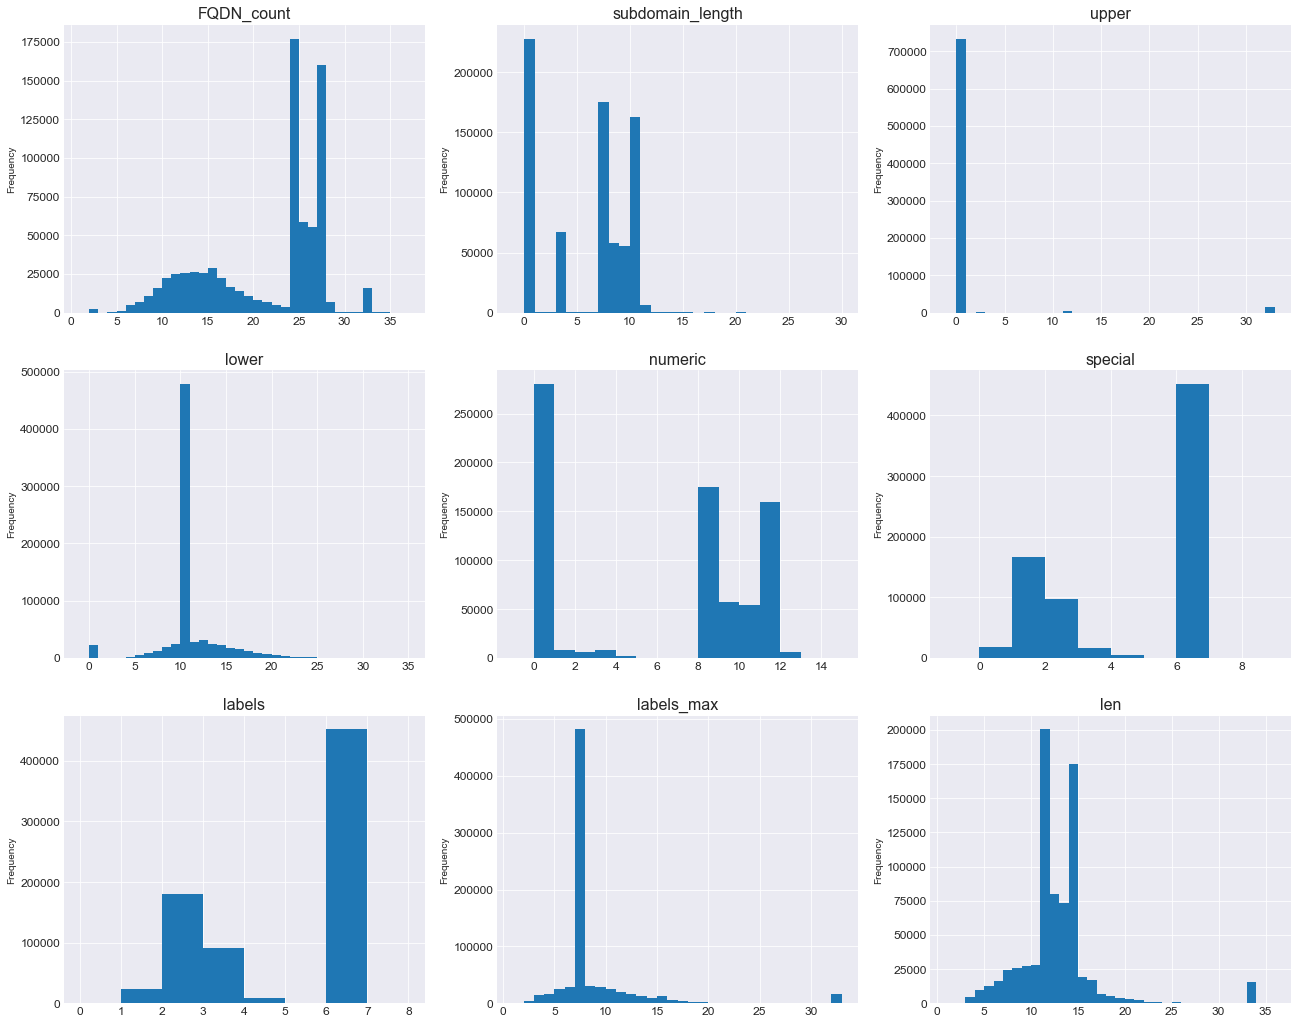

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [13]:
fig, axs = plt.subplots(3,3, figsize = (22,18))
i=0
j=0
for column in list(df.columns):
    if column in ["timestamp", "entropy", "labels_average", "longest_word", "sld", "subdomain", 'original_index', 'data_type', 'Target Attack', 'origin']:
        continue # skip the non-numerical and continuous features
    plt.figure()
    df[column].plot(kind="hist", bins=[i for i in range(int(min(df[column])-1), int(max(df[column])+2))], ax=axs[i,j], fontsize=12)
    
    axs[i,j].set_title(column, fontdict={'fontsize':16})
    if j < 2:
        j+=1
    else:
        i += 1
        j = 0
plt.show()


We replot this with very granular ticks to see the values:

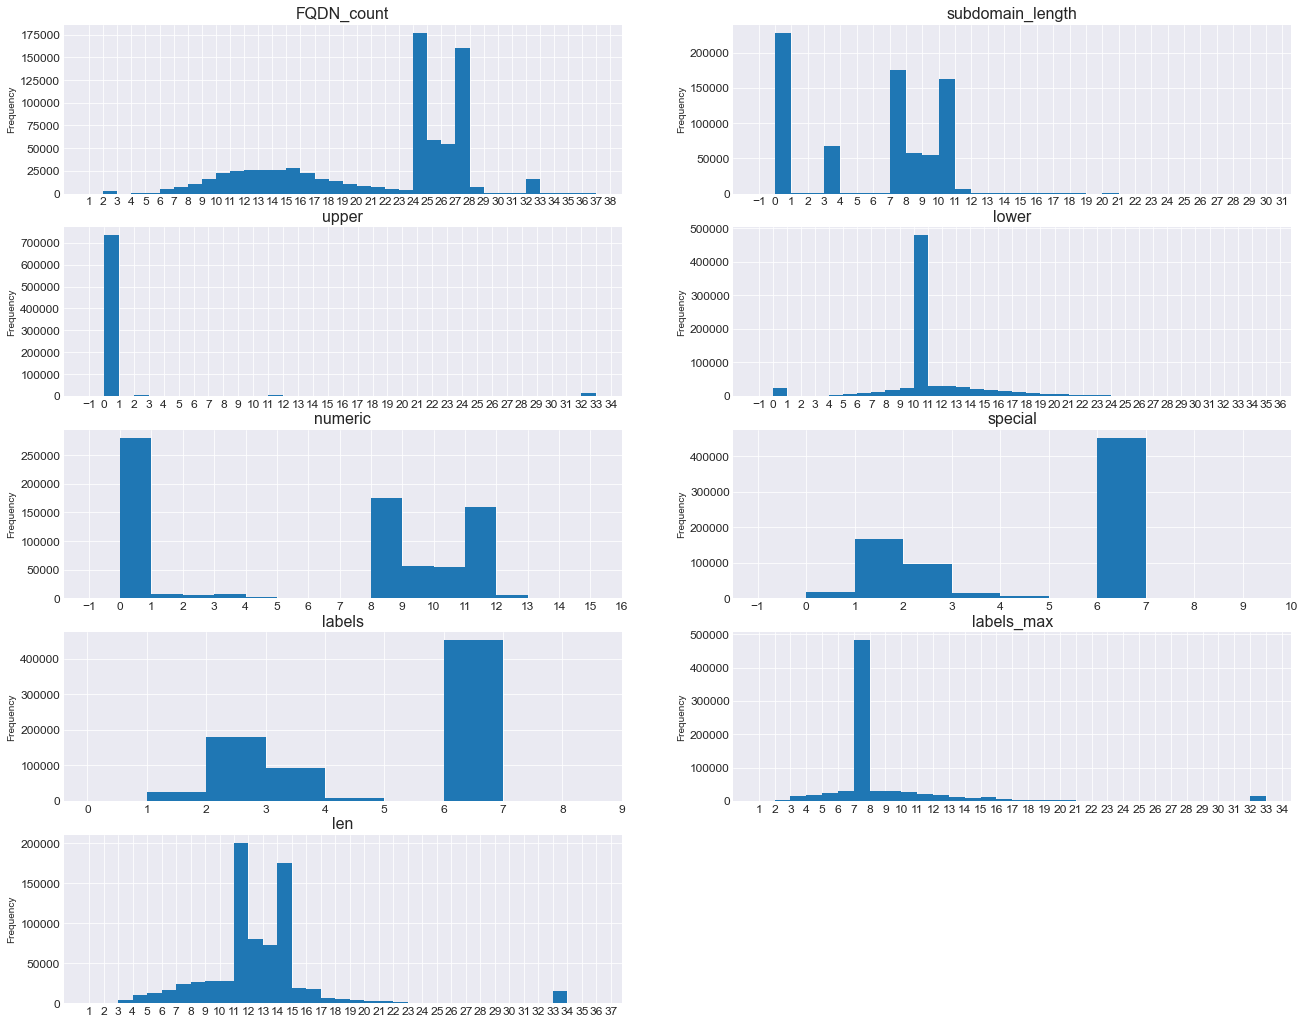

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [14]:
fig, axs = plt.subplots(5,2, figsize = (22,18))
i=0
j=0
for column in list(df.columns):
    if column in ["timestamp", "entropy", "labels_average", "longest_word", "sld", "subdomain", 'original_index', 'data_type', 'Target Attack', 'origin']:
        continue # skip the non-numerical and continuous features
    plt.figure()
    df[column].plot(kind="hist", bins=[i for i in range(int(min(df[column])-1), int(max(df[column])+2))], ax=axs[i,j], fontsize=12)
    
    axs[i,j].set_title(column, fontdict={'fontsize':16})
    axs[i,j].set_xticks([i for i in range(int(min(df[column])-1), int(max(df[column])+1)+2)], rotation=90)
    if j < 1:
        j+=1
    else:
        i += 1
        j = 0

fig.delaxes(axs[4][1])

plt.show()


The following shows the percentile-based breakdown of this data. 

In [15]:
for column in list(df.columns):
    if column in ["timestamp", "entropy", "longest_word", "labels_average", "sld", "subdomain", "Target Attack"]:
        continue # skip the non-numerical features
    display(pd.DataFrame(df[column].describe(percentiles=[i/100 for i in range (0, 100, 10)])).T)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
FQDN_count,757211.0,21.209139,6.499343,2.0,2.0,11.0,14.0,17.0,24.0,24.0,24.0,26.0,27.0,27.0,36.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
subdomain_length,757211.0,5.446479,4.056687,0.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,8.0,10.0,10.0,29.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
upper,757211.0,0.740263,4.62932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
lower,757211.0,10.577114,3.36903,0.0,0.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,12.0,15.0,34.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
numeric,757211.0,5.734658,4.699701,0.0,0.0,0.0,0.0,0.0,4.0,8.0,8.0,9.0,11.0,11.0,14.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
special,757211.0,4.157104,2.297475,0.0,0.0,1.0,1.0,2.0,4.0,6.0,6.0,6.0,6.0,6.0,8.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
labels,757211.0,4.503103,1.868668,1.0,1.0,2.0,2.0,3.0,4.0,6.0,6.0,6.0,6.0,6.0,7.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
labels_max,757211.0,8.225188,4.313897,2.0,2.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,9.0,12.0,32.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
len,757211.0,12.261901,4.228035,2.0,2.0,8.0,11.0,11.0,11.0,12.0,13.0,14.0,14.0,15.0,35.0


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
original_index,757211.0,34553.066645,28447.273989,0.0,0.0,4489.0,9758.0,15546.0,21683.0,27993.0,34303.0,43828.0,55567.0,72675.0,132498.0


,count,unique,top,freq
data_type,757211,7,benign,462858


,count,unique,top,freq
origin,757211,5,heavy-attack,251670


### Brief summary of the numerical features
   

1. FQDN Count: The number of characters in the FQDN is generally spread out with two main peaks at around 23-29 characters and a smaller peak around 9-19 characters. Longer FQDNs are associated with more attacks as seen below.


In [18]:
df[df["FQDN_count"]<23]["Target Attack"].value_counts(normalize=True)

0    0.971702
1    0.028298
Name: Target Attack, dtype: float64

In [19]:
df[df["FQDN_count"]>23]["Target Attack"].value_counts(normalize=True)

1    0.602429
0    0.397571
Name: Target Attack, dtype: float64

2. Subdomain_length: Around 30% of the queries have a subdomain length of zero, which is consistent with the previous analysis of the "subdomain" feature. The following two code cells verify this to make sure the data is not incorrect. There are peaks at length 0, 7, and 10, and smaller peaks at length 3, 8, and 9.

In [16]:
df[df["subdomain_length"]==0]["subdomain"].value_counts()

0    228121
Name: subdomain, dtype: int64

In [17]:
df[df["subdomain"]==0]["subdomain_length"].value_counts()

0    228121
Name: subdomain_length, dtype: int64

3. upper: The majority of the queries have no uppercase characters. There are tiny peaks at length 2, 11, and 32.
4. lower: More than half the queries have exactly 10 lowercase characters, with the first quartile, second quartile (median), and third quartile all having exactly 10 lowercase characters. The rest of the data is spread out around the median. A small proportion of the data has no lowercase characters at all.
5. numeric: About 30% of the data have no numeric characters in the queries. About a quarter of the queries have exactly 8 and exactly 11 numeric characters respectively. Besides these large peaks, there are smaller peaks at 9-10 numeric characters. The rest of the data is more spread out around these peaks.
6. special: About 50% of the data has exactly 6 special characters, with the rest concentrated arond 0-5, with a smaller peak at 1. Between 0 and 5, almost all the queries are benign instances (96%).


In [18]:
df[(df["special"]>0) & (df["special"]<5)]["Target Attack"].value_counts(normalize=True)

0    0.978721
1    0.021279
Name: Target Attack, dtype: float64

7. labels: About 68% of the data has exactly 6 labels, with the rest concentrated arond 1-4, with a smaller peak at 2. Between 1-4, almost all the queries are benign instances (98%).

In [23]:
df[(df["labels"]>1) & (df["labels"]<4)]["Target Attack"].value_counts(normalize=True)

0    0.989043
1    0.010957
Name: Target Attack, dtype: float64

8. labels_max: About 60% of the data has a maximum label length of exactly 7, with the rest concentrated close to this peak (standard deviation=4.3). There is also a small peak at 32

In [21]:
df[df["labels_max"]==32]["Target Attack"].value_counts(normalize=True)

1    0.61349
0    0.38651
Name: Target Attack, dtype: float64

9. len: About 60-70% of the data has a length within 11-14, with about a quarter of queries having a length of exactly 11 and exactly 14 respectively. The rest of the data is concentrated close to this peak (standard deviation=4.2). There is another small peak at 33.

In [20]:
df[df["len"]==33]["Target Attack"].value_counts(normalize=True)

1    0.613372
0    0.386628
Name: Target Attack, dtype: float64

## Visualizing the distribution of continuous numerical features 

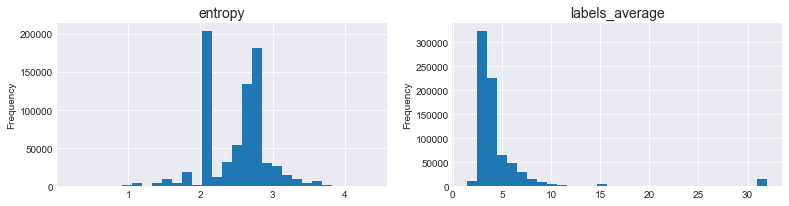

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(13,3))

for i,column in enumerate(["entropy", "labels_average"]):
    plt.figure()
    df[column].plot(kind="hist", ax=axs[i], bins=30)
    
    axs[i].set_title(column, fontdict={'fontsize':14})
    #axs[i].set_xticks([i for i in range(int(min(df[column])-1), int(max(df[column])+1)+2)], rotation=90)
    #print(df[column].describe())
#fig.tight_layout()
plt.show()


In [23]:
for column in ["entropy", "labels_average"]:
    display(pd.DataFrame(df[column].describe(percentiles=[i/100 for i in range (0, 100, 10)])).T)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
entropy,757211.0,2.481558,0.427002,0.219195,0.219195,2.054029,2.054029,2.12059,2.530857,2.570417,2.595489,2.742338,2.767195,2.952882,4.368167


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
labels_average,757211.0,4.830908,4.321089,1.5,1.5,3.166667,3.166667,3.333333,3.5,3.666667,3.666667,4.0,5.333333,7.0,32.0


1. Entropy:
The entropy values are concentrated between 2.0 and 2.8, with a decreasing proportion outside of this range. There is a sudden drop between approximately between 2.05 and 2.5. But these samples are more likely to be benign as seen below:

In [24]:
df[(df["entropy"] > 2.055) & (df["entropy"] < 2.5)]["Target Attack"].value_counts(normalize=True)

0    0.935473
1    0.064527
Name: Target Attack, dtype: float64

2. labels_average: The average label length is heavily concentrated at around 3.0 to 3.7, with a decreasing proportion outside this range. There is a small proportion of outliers with an average label length over 30.

In [26]:
df[(df["labels_average"] > 30) ]["Target Attack"].value_counts(normalize=True)

1    0.614038
0    0.385962
Name: Target Attack, dtype: float64

## Visualizing the distribution of features with mixed data types

In [27]:

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(str(word for word in df.longest_word)))


1. Longest Word: The most common longest words are single digits like "2", "4", etc. or single letters like "C" or "N". Other common words are "local", "microsoft", "online", etc., as can be seen in the word cloud. Examples with the longest word longer than a single digit or letter are almost always benign (97%). Examples with only lowercase letters seem to be benign most of the time (97%) and those with only uppercase letters or numeric strings have a higher chance of being attacks (76% each). 

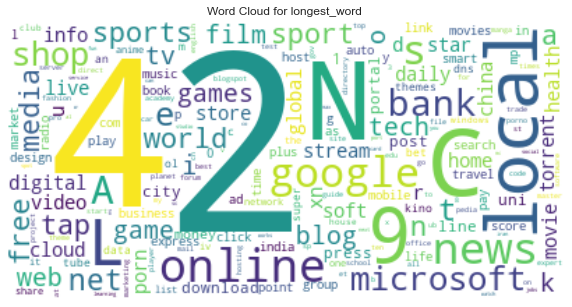

In [28]:
plt.figure(figsize = (10,10))
plt.imshow(word_cloud.generate_from_frequencies(dict(df["longest_word"].value_counts(dropna=False))), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for longest_word ", fontsize=12)
plt.show()

The following blocks of code attempt to view which regions of the input space is associated with attacks vs benign examples.

In [29]:
df[(df["longest_word"].str.len()>1)]["Target Attack"].value_counts(normalize=True)

0    0.985878
1    0.014122
Name: Target Attack, dtype: float64

In [30]:
df[(df["longest_word"].str.isupper()) & (df["longest_word"].notna())]["Target Attack"].value_counts(normalize=True)

1    0.612058
0    0.387942
Name: Target Attack, dtype: float64

In [31]:
df[(df["longest_word"].str.isupper()) & (df["longest_word"].str.len()>1) ]["Target Attack"].value_counts(normalize=True)

Series([], Name: Target Attack, dtype: float64)

In [32]:
df[(df["longest_word"].str.islower()) & (df["longest_word"].notna())]["Target Attack"].value_counts(normalize=True)

0    0.986296
1    0.013704
Name: Target Attack, dtype: float64

In [33]:
df[(df["longest_word"].str.isnumeric()) & (df["longest_word"].notna())]["Target Attack"].value_counts(normalize=True)

1    0.609123
0    0.390877
Name: Target Attack, dtype: float64

In [34]:
df[(df["longest_word"].str.len()==1) & (df["longest_word"].str.islower())]["Target Attack"].value_counts(normalize=True)

0    1.0
Name: Target Attack, dtype: float64

In [45]:
df[(df["longest_word"].str.len()==1) & (df["longest_word"].str.isupper()) ]["Target Attack"].value_counts(normalize=True)

1    0.612058
0    0.387942
Name: Target Attack, dtype: float64

2. sld: The most common second level domains are numbers like 192, 224 (parts of IP addresses) and long sequences of strings like "FHEPFCELEHFCEPFFFACACACACACACABN" or "DESKTOP-3JF04TC". There is a small proportion of human-readable strings like dns, wpad, microsoft, google, etc., as in the word cloud. When the length of a sld is more than 3, i.e., when excluding examples with components of IP addresses (and also short words), most of the samples are benign (>90%). 
When there are only letters, it is more likely to be benign, and when there are only digits, it is more likely to be an attack. In the data, when both letters and numbers are present (but no special characters), most of the cases are benign.

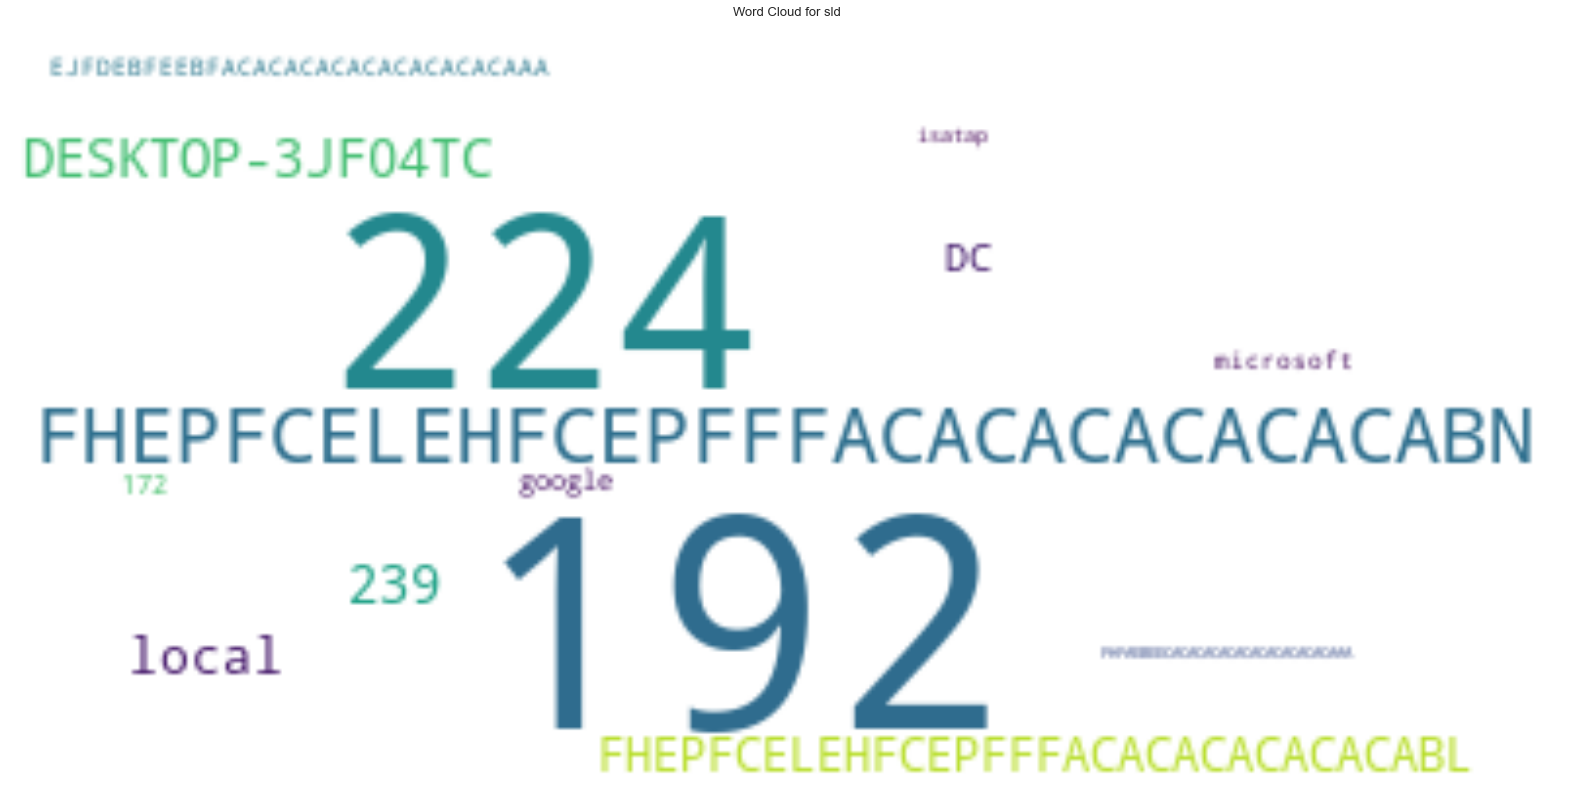

In [46]:
plt.figure(figsize = (28,28))
plt.imshow(word_cloud.generate_from_frequencies(dict(df["sld"].value_counts(dropna=False))), interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for sld ", fontsize=13)
plt.show()


The following blocks of code attempt to view which regions of the input space is associated with attacks vs benign examples.

In [47]:
df[(df["sld"].str.len()>3)]["Target Attack"].value_counts(normalize=True)

0    0.942993
1    0.057007
Name: Target Attack, dtype: float64

In [48]:
df[(df["sld"].str.isnumeric())]["Target Attack"].value_counts(normalize=True)

1    0.610172
0    0.389828
Name: Target Attack, dtype: float64

In [49]:
df[(df["sld"].str.len()<=3) & (df["sld"].str.isnumeric())]["Target Attack"].value_counts(normalize=True)

1    0.61081
0    0.38919
Name: Target Attack, dtype: float64

In [40]:
df[(df["sld"].str.isalpha())]["Target Attack"].value_counts(normalize=True)

0    0.941815
1    0.058185
Name: Target Attack, dtype: float64

In [41]:
df[(df["sld"].str.len()<=3) & (df["sld"].str.isalpha())]["Target Attack"].value_counts(normalize=True)

0    0.904304
1    0.095696
Name: Target Attack, dtype: float64

In [50]:
df[(df["sld"].str.isalnum()) & (~df["sld"].str.isalpha()) & (~df["sld"].str.isnumeric())]["Target Attack"].value_counts(normalize=True)


0    0.99975
1    0.00025
Name: Target Attack, dtype: float64

In [53]:
df[(df["sld"].str.isalnum()) & (~df["sld"].str.isalpha()) & (~df["sld"].str.isnumeric())]["sld"].sample(5)

348084             1a
207112    4reifen1klo
91683          52miji
28936        gfxtra31
332872       2048game
Name: sld, dtype: object

In [56]:
df[~(df["sld"].str.isalnum())]["Target Attack"].value_counts(normalize=True)

0    0.901927
1    0.098073
Name: Target Attack, dtype: float64

# Feature Engineering and Data Cleaning

## Checking for missing values:

In [57]:
for col in df.columns:
    print(f"Percentage of missing values in {col} : {df[col].isna().sum()/df.shape[0]}")

Percentage of missing values in timestamp : 0.0
Percentage of missing values in FQDN_count : 0.0
Percentage of missing values in subdomain_length : 0.0
Percentage of missing values in upper : 0.0
Percentage of missing values in lower : 0.0
Percentage of missing values in numeric : 0.0
Percentage of missing values in entropy : 0.0
Percentage of missing values in special : 0.0
Percentage of missing values in labels : 0.0
Percentage of missing values in labels_max : 0.0
Percentage of missing values in labels_average : 0.0
Percentage of missing values in longest_word : 4.093971165236638e-05
Percentage of missing values in sld : 0.0
Percentage of missing values in len : 0.0
Percentage of missing values in subdomain : 0.0
Percentage of missing values in original_index : 0.0
Percentage of missing values in data_type : 0.0
Percentage of missing values in Target Attack : 0.0
Percentage of missing values in origin : 0.0


Fill in missing values:

In [58]:
df["longest_word"].fillna("", inplace=True)

## Handling categorical values:

As seen in the data analysis section, the length of the words in the "longest_word" and "sld" columns are quite informative, so we create two new features for the lengths of these columns:

In [59]:
df["longest_word_length"] = df["longest_word"].apply(len)
df["sld_length"] = df["sld"].apply(len)

Text(0.5, 1.0, 'Distribution of the length of the longest word')

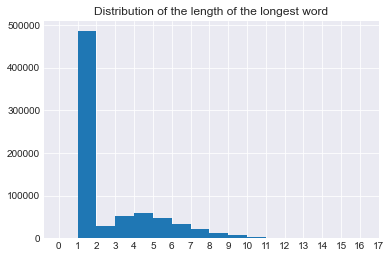

In [60]:
plt.hist(df["longest_word_length"], bins=16)
plt.xticks([i for i in range(18)])
plt.title("Distribution of the length of the longest word")

In [61]:
print("% of the longest words that are of length 1 is : ", perc(df[df["longest_word_length"]==1].shape[0]/df.shape[0])) 

% of the longest words that are of length 1 is :  64.07%


For the single-character longest word, we look at all the possible unique values within the data:

In [62]:
df[df["longest_word_length"]==1]["longest_word"].unique()

array(['2', '4', '9', 'C', '0', 'N', 'k', '8', '6', '3', 's', 'e', 't',
       '1', 'x', 'g', 'L', 'c', 'w', 'r', 'h', 'u', 'v', 'n', 'm', 'o',
       'z', 'l', 'b', 'y', 'f', 'a', '5', 'd', 'A', 'i', '7', 'p', 'j',
       'q', 'M', '_'], dtype=object)

Since these make up 72% of the data, it might be worthwhile to encode them in a special way. Hence, another feature will be created that takes the ASCII values of the letters and the raw numbers for digits.

In [63]:
def single_char_longest_word(x):
    if len(x) != 1:
        return -1
    else:
        if x.isnumeric():
            return int(x)
        else:
            return ord(x)

In [64]:
df["longest_word_single_char"] = df["longest_word"].apply(single_char_longest_word)

Text(0.5, 1.0, 'Distribution of the length of the sld')

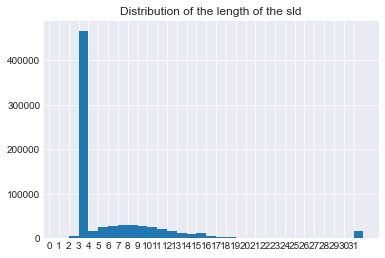

In [65]:
plt.hist(df["sld_length"], bins=31)
plt.xticks([i for i in range(32)])
plt.title("Distribution of the length of the sld")

In [66]:
print("% of the sld that are of length 3 is : ", perc(df[df["sld_length"]==3].shape[0]/df.shape[0])) 

% of the sld that are of length 3 is :  61.53%


In [67]:
df[df["sld_length"]==3]["sld"].value_counts(normalize=True)[:10]

192    0.583250
224    0.374711
239    0.010172
172    0.002267
dns    0.000410
gov    0.000264
uol    0.000200
www    0.000191
olx    0.000146
edu    0.000127
Name: sld, dtype: float64

Since a high proportion of the three-character sld values are predominantly numeric in nature, we can encode them separately.

In [68]:
def three_char_sld(x):
    if len(x) == 3 and x.isnumeric():
        return int(x)
    else:
        return -1

In [69]:
df["sld_three_char"] = df["sld"].apply(three_char_sld)

We also create similar features for lowercase, uppercase, numeric, and alphanumeric

In [102]:
df["longest_word_islower"] = df["longest_word"].apply(lambda x: str(x).islower())
df["longest_word_isupper"] = df["longest_word"].apply(lambda x: str(x).isupper())
df["longest_word_isnumeric"] = df["longest_word"].apply(lambda x: str(x).isnumeric())
df["longest_word_isalnum"] = df["longest_word"].apply(lambda x: str(x).isalnum())
df["sld_islower"] = df["sld"].apply(lambda x: str(x).islower())
df["sld_isupper"] = df["sld"].apply(lambda x: str(x).isupper())
df["sld_isnumeric"] = df["sld"].apply(lambda x: str(x).isnumeric())
df["sld_isalnum"] = df["sld"].apply(lambda x: str(x).isalnum())


Further, the columns "longest_word" and "sld" can be embedded with either hashing or ordinal encoding (among other methods). This will be done in the Cross Validation stage through a pipeline to ensure no data leakage between the train and test datasets.

# Feature Selection methods:

For the numeric features, we use One-Way ANOVA to select the top 15 out of 20 features.

For the categorical features, we use the Chi-Square Test to investigate the predictive ability of the two categorical features.

## One-Way ANOVA

In [71]:
skf = StratifiedKFold(n_splits=5)
X = df[[col for col in df.columns if col not in ["timestamp", "longest_word", "longest_word_single_char", "sld_three_char", "sld", "subdomain", 'original_index', 'data_type', 'Target Attack', 'origin']]]
y = df["Target Attack"]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    selector = SelectKBest(f_classif, k=15)
    selector.fit(X_train, y_train)
    cols = selector.get_support(indices=True)
    #print(cols)

In [72]:
print("Accepted Features:")
print(selector.get_feature_names_out())


Accepted Features:
['FQDN_count' 'subdomain_length' 'lower' 'numeric' 'special' 'labels'
 'len' 'longest_word_length' 'sld_length' 'longest_word_islower'
 'longest_word_isnumeric' 'sld_islower' 'sld_isupper' 'sld_isnumeric'
 'sld_isalnum']


In [73]:
print("The features that are rejected are: ", [col for col in X.columns if col not in selector.get_feature_names_out()])

The features that are rejected are:  ['upper', 'entropy', 'labels_max', 'labels_average', 'longest_word_isupper', 'longest_word_isalnum']


In [74]:
print("p-values of all features:")
print(selector.pvalues_)

p-values of all features:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.77496024e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


## Chi-Square Test

Code adapted from https://www.analyticsvidhya.com/blog/2021/06/feature-selection-using-statistical-tests/

### sld


In [75]:
skf = StratifiedKFold(n_splits=5)
X = df[["longest_word", "sld"]]
y = df["Target Attack"]
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    sld_df = pd.crosstab(X_train["sld"], y_train)
    observed=sld_df.values
    val2=stats.chi2_contingency(sld_df)
    expected=val2[3]
    chi_square=sum([(o-e)**2./e for o,e in zip(observed,expected)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    p_value=1-stats.chi2.cdf(x=chi_square_statistic,df=(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print(f"Fold {i+1}: ")
    print("chi-square statistic:-",chi_square_statistic)
    print('Degree of Freedom: ',(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print('p-value:',p_value)
    

Fold 1: 
chi-square statistic:- 220715.55915926647
Degree of Freedom:  53262
p-value: 0.0
Fold 2: 
chi-square statistic:- 224450.3306780687
Degree of Freedom:  53110
p-value: 0.0
Fold 3: 
chi-square statistic:- 218361.14479317897
Degree of Freedom:  61926
p-value: 0.0
Fold 4: 
chi-square statistic:- 218008.6161708628
Degree of Freedom:  62554
p-value: 0.0
Fold 5: 
chi-square statistic:- 221688.5078127757
Degree of Freedom:  52107
p-value: 0.0


### sld_3_char

In [76]:

skf = StratifiedKFold(n_splits=5)
X = df[["longest_word", "sld_three_char"]]
y = df["Target Attack"]
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    sld_df = pd.crosstab(X_train["sld_three_char"], y_train)
    observed=sld_df.values
    val2=stats.chi2_contingency(sld_df)
    expected=val2[3]
    chi_square=sum([(o-e)**2./e for o,e in zip(observed,expected)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    p_value=1-stats.chi2.cdf(x=chi_square_statistic,df=(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print(f"Fold {i+1}: ")
    print("chi-square statistic:-",chi_square_statistic)
    print('Degree of Freedom: ',(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print('p-value:',p_value)
    

Fold 1: 
chi-square statistic:- 187058.53824324222
Degree of Freedom:  25
p-value: 0.0
Fold 2: 
chi-square statistic:- 190712.41828609916
Degree of Freedom:  49
p-value: 0.0
Fold 3: 
chi-square statistic:- 184816.622966515
Degree of Freedom:  52
p-value: 0.0
Fold 4: 
chi-square statistic:- 184707.73378135927
Degree of Freedom:  49
p-value: 0.0
Fold 5: 
chi-square statistic:- 188185.03043379384
Degree of Freedom:  49
p-value: 0.0


### longest_word

In [77]:
skf = StratifiedKFold(n_splits=5)
X = df[["longest_word", "sld"]]
y = df["Target Attack"]
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    sld_df = pd.crosstab(X_train["longest_word"], y_train)
    observed=sld_df.values
    val2=stats.chi2_contingency(sld_df)
    expected=val2[3]
    chi_square=sum([(o-e)**2./e for o,e in zip(observed,expected)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    p_value=1-stats.chi2.cdf(x=chi_square_statistic,df=(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print(f"Fold {i+1}: ")
    print("chi-square statistic:-",chi_square_statistic)
    print('Degree of Freedom: ',(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print('p-value:',p_value)
    

Fold 1: 
chi-square statistic:- 219768.93144288578
Degree of Freedom:  16168
p-value: 0.0
Fold 2: 
chi-square statistic:- 223309.6812388748
Degree of Freedom:  15911
p-value: 0.0
Fold 3: 
chi-square statistic:- 217139.84097340034
Degree of Freedom:  17185
p-value: 0.0
Fold 4: 
chi-square statistic:- 216784.15779587824
Degree of Freedom:  17269
p-value: 0.0
Fold 5: 
chi-square statistic:- 220592.82733805804
Degree of Freedom:  15582
p-value: 0.0


### longest_word_single_char

In [78]:
skf = StratifiedKFold(n_splits=5)
X = df[["longest_word_single_char", "sld"]]
y = df["Target Attack"]
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    sld_df = pd.crosstab(X_train["longest_word_single_char"], y_train)
    observed=sld_df.values
    val2=stats.chi2_contingency(sld_df)
    expected=val2[3]
    chi_square=sum([(o-e)**2./e for o,e in zip(observed,expected)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    p_value=1-stats.chi2.cdf(x=chi_square_statistic,df=(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print(f"Fold {i+1}: ")
    print("chi-square statistic:-",chi_square_statistic)
    print('Degree of Freedom: ',(sld_df.shape[0]-1)*(sld_df.shape[1]-1))
    print('p-value:',p_value)
    

Fold 1: 
chi-square statistic:- 212316.43897543137
Degree of Freedom:  42
p-value: 0.0
Fold 2: 
chi-square statistic:- 216210.42723011543
Degree of Freedom:  41
p-value: 0.0
Fold 3: 
chi-square statistic:- 209985.31473450374
Degree of Freedom:  42
p-value: 0.0
Fold 4: 
chi-square statistic:- 209661.4053031432
Degree of Freedom:  42
p-value: 0.0
Fold 5: 
chi-square statistic:- 213532.35860355367
Degree of Freedom:  42
p-value: 0.0


Based on the p-values, the categorical features appear to be useful in predicting an attack, and will be used in the model.

# Examining the distributions among the exfiltrated data file types:

## Discrete Features

In [81]:
df.data_type.unique()

array(['benign', 'audio', 'compressed', 'exe', 'image', 'text', 'video'],
      dtype=object)

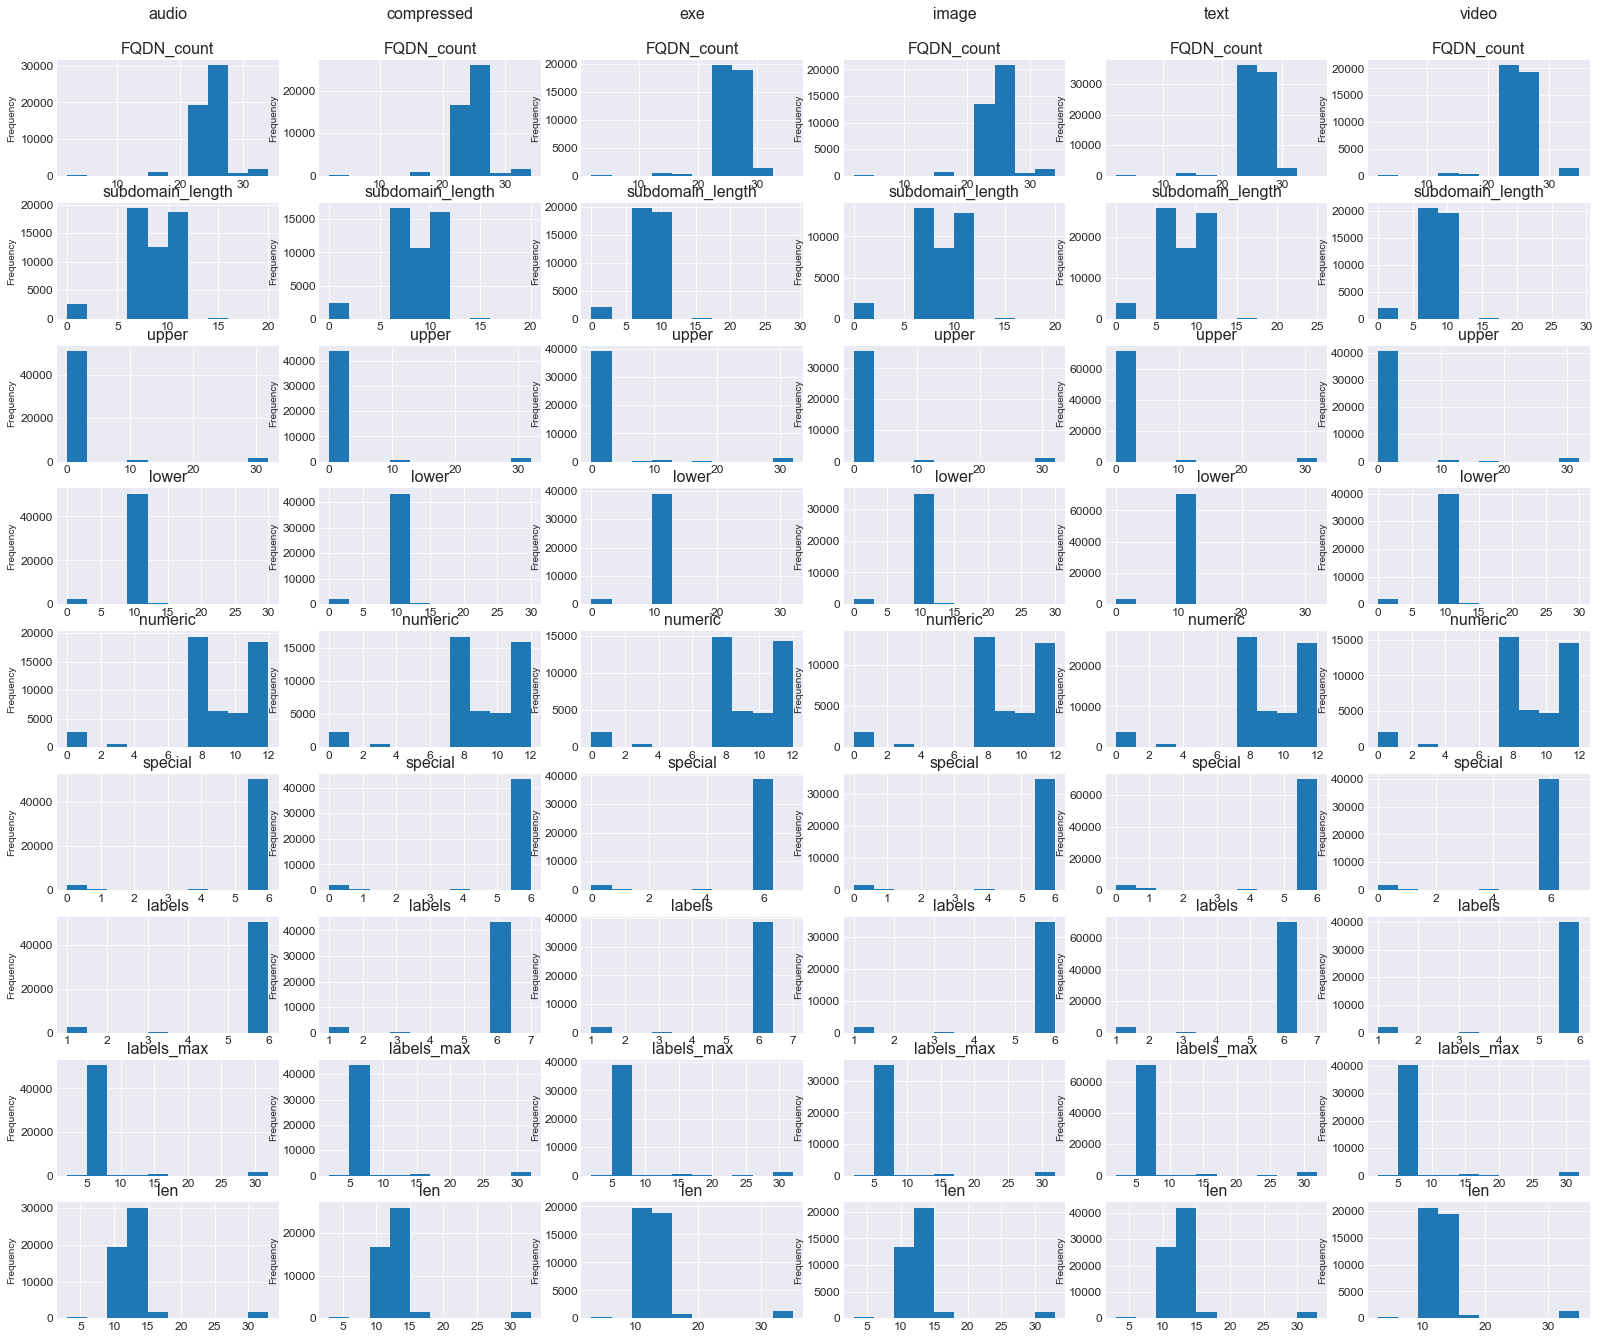

In [109]:
fig, axs = plt.subplots(9,6, figsize = (22,18))
i=0
j=0
fig.tight_layout()
for data_type in df.data_type.unique():
    
    if data_type=="benign":
        continue
    subset = df[df.data_type==data_type]
    for column in list(df.columns):
        #print(i,j, column)
        if column in ["timestamp", "entropy", "labels_average", "longest_word", "sld", "subdomain", 'original_index', 'data_type', 'Target Attack', 'origin']:
            continue # skip the non-numerical and continuous features
        if column.startswith("longest") or column.startswith("sld"):
            continue
        #plt.figure()
        subset[column].plot(kind="hist", ax=axs[i,j], fontsize=12)
        if i == 0:
            axs[i,j].set_title(data_type + "\n\n" + column, fontdict={'fontsize':16})
        else:
            axs[i,j].set_title(column, fontdict={'fontsize':16})
        if i < 8:
            i += 1
        else:
            i = 0
            j += 1
    i = 0
#         if j < 2:
#             j+=1
#         else:
#             i += 1
#             j = 0
plt.show()

## Continuous features:

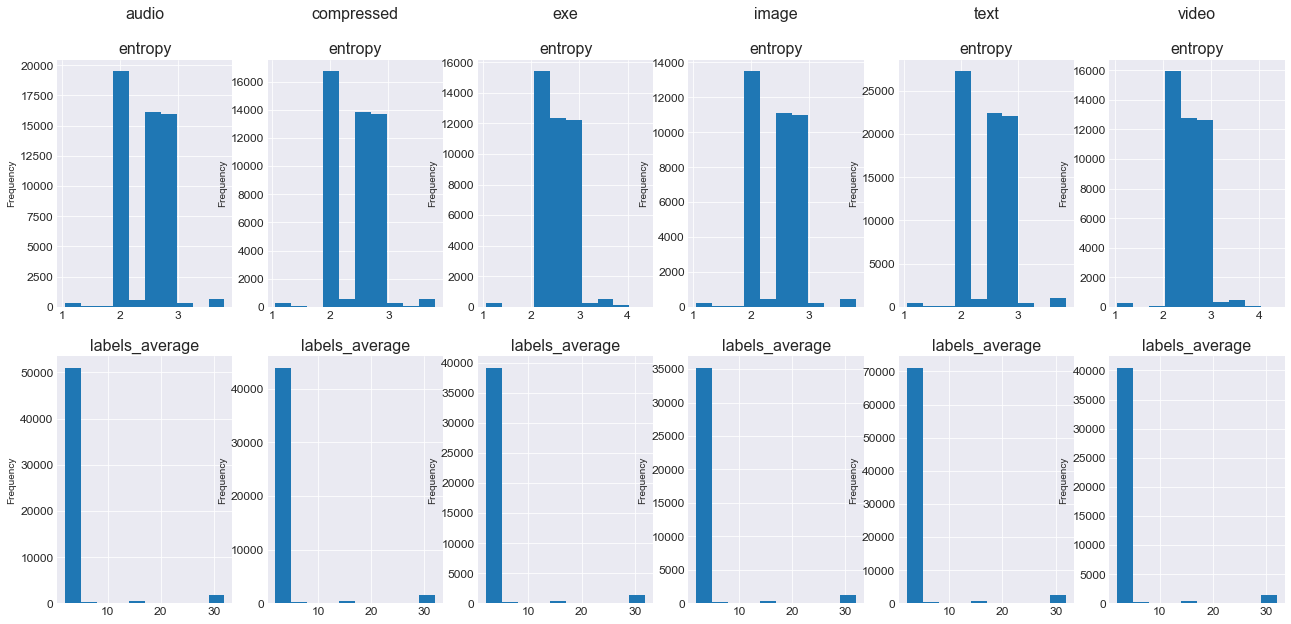

In [122]:
fig, axs = plt.subplots(2,6, figsize = (22,10))
i=0
j=0
#fig.tight_layout()
for data_type in df.data_type.unique():
    
    if data_type=="benign":
        continue
    subset = df[df.data_type==data_type]
    for column in ["entropy", "labels_average"]:
        #print(i,j, column, data_type)
        subset[column].plot(kind="hist", ax=axs[i,j], fontsize=12)
        if i == 0:
            axs[i,j].set_title(data_type + "\n\n" + column, fontdict={'fontsize':16})
        else:
            axs[i,j].set_title(column, fontdict={'fontsize':16})
        if i < 2:
            i += 1
        else:
            i = 0
    j += 1
    i = 0

plt.show()



The distribution among the different types is similar, but does have slight differences. Perhaps ensembling on the different data types would help. 